# Demo Workflow

In [1]:
import model_catalogs as mc

import intake
import pandas as pd

import os

import xarray as xr


## Source catalog

This is useful for getting baseline metadata about a model. The source catalog is all hard-wired and does not access the actual model files.

In [2]:
source_cat = mc.setup_source_catalog()

See what model options are available with:

In [3]:
list(source_cat)

['NYOFS',
 'CBOFS_REGULARGRID',
 'LMHOFS_REGULARGRID',
 'LEOFS_REGULARGRID',
 'WCOFS_REGULARGRID',
 'RTOFS-EAST',
 'RTOFS-ALASKA',
 'GOMOFS_REGULARGRID',
 'CIOFS_REGULARGRID',
 'NGOFS2_2DS',
 'TBOFS',
 'GFS-1_2DEG',
 'NGOFS2',
 'RTOFS-GLOBAL_2D',
 'GFS-1DEG',
 'SFBOFS_REGULARGRID',
 'HYCOM',
 'RTOFS-GLOBAL',
 'CIOFS',
 'LMHOFS',
 'DBOFS',
 'LEOFS',
 'DBOFS_REGULARGRID',
 'WCOFS_2DS',
 'SFBOFS',
 'GFS-1_4DEG',
 'NGOFS2_REGULARGRID',
 'RTOFS-WEST',
 'TBOFS_REGULARGRID',
 'LOOFS',
 'WCOFS',
 'GOMOFS',
 'CREOFS',
 'GOMOFS_2DS',
 'LSOFS',
 'CBOFS',
 'CREOFS_REGULARGRID']

### Complete source catalog files

If the "complete" versions of the models, which contain the boundary information for the model, are not yet available, a message will print and you can run them with:

`source_cat = mc.complete_source_catalog()`

Or, if you know you want to rerun the "complete" model files you can just force it to rerun them all by calling `source_cat = mc.complete_source_catalog()` in the first place. Or, delete the "complete" catalog directory.

In [5]:
%%time
source_cat = mc.complete_source_catalog()

/Users/kthyng/miniconda3/envs/model_catalogs/lib/python3.8/site-packages/alphashape/alphashape.py:112: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(points) < 4 or (alpha is not None and not callable(
/Users/kthyng/projects/LibGOODS/model_catalogs/model_catalogs/utils.py:98: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  p1 = alphashape.alphashape(pts, alpha)
/Users/kthyng/miniconda3/envs/model_catalogs/lib/python3.8/site-packages/alphashape/alphashape.py:112: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(points) < 4 or (alpha is not No

CPU times: user 3min 35s, sys: 5.7 s, total: 3min 41s
Wall time: 5min 44s


source_catalog.yaml:
  args:
    description: Source catalog for models.
    name: source_catalog.yaml
  description: Source catalog for models.
  driver: intake.catalog.base.Catalog
  metadata:
    source_catalog_dir: /Users/kthyng/projects/LibGOODS/model_catalogs/model_catalogs/catalogs/complete


### Examine metadata of models in source catalog

Now the source catalog has all hard-wired information about the models plus the domain boundary information. This is available in `source_cat`. 

#### Domain boundaries

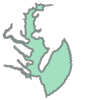

In [7]:
import shapely.wkt

P = shapely.wkt.loads(source_cat['CBOFS'].metadata['geospatial_bounds'])
P

#### Variables

A mapping for the relevant variables to NOAA applications has been written into each source catalog. The mapping is between a standard CF convention variable name to the model dataset variable name. The list of possible variables used is:

        eastward_sea_water_velocity
        eastward_wind
        northward_sea_water_velocity
        northward_wind
        sea_floor_depth
        sea_ice_area_fraction
        sea_ice_thickness
        sea_surface_height_above_mean_sea_level
        sea_water_temperature
        sea_water_practical_salinity
        time
        upward_sea_water_velocity

Examine the variable mapping for a given model:

In [8]:
source_cat['CBOFS']['forecast'].metadata['standard_names']

{'eastward_sea_water_velocity': 'u',
 'eastward_wind': 'Uwind',
 'northward_sea_water_velocity': 'v',
 'northward_wind': 'Vwind',
 'ocean_s_coordinate_g1': ['s_rho', 's_w'],
 'sea_floor_depth': 'h',
 'sea_surface_height_above_mean_sea_level': 'zeta',
 'sea_water_practical_salinity': 'salt',
 'sea_water_temperature': 'temp',
 'time': 'time',
 'upward_sea_water_velocity': 'w'}

## Find available for model output

You can query a specific model for its availability for specifically the forecast and hindcast timing, as below. This is not a necessary step, but is useful for a user choosing the model to use and what is possible. The date range information is saved in an "updated" version of the model catalog file.

This will take 10 seconds to 1 minute if the model availability has not been checked recently "enough", according to a "stale" parameter. Currently a forecast is stale after 4 hours and a hindcast is stale after 1 day.

In [9]:
%%time
cat = mc.find_availability(model='CIOFS')

CPU times: user 878 ms, sys: 64.4 ms, total: 942 ms
Wall time: 9.84 s


This is fast the second time when the "updated" version of the model catalog is fresh instead of stale.

In [10]:
%%time
cat = mc.find_availability(model='CIOFS')

CPU times: user 71.1 ms, sys: 3.86 ms, total: 75 ms
Wall time: 81.5 ms


Timing metadata is now available:

In [11]:
print('forecast: ', cat['forecast'].metadata['start_datetime'], ' to ', cat['forecast'].metadata['end_datetime'])
print('hindcast: ', cat['hindcast'].metadata['start_datetime'], ' to ', cat['hindcast'].metadata['end_datetime'])

forecast:  2022-03-18T01:00:00.000000000  to  2022-03-27T12:00:00.000000000
hindcast:  2019-09-17 01:00:00  to  2022-03-23 00:00:00


## Request model output for desired date range

Use this to then actually read model output in. Since `find_availability` was previous run, the model knows when it is available and can decide which source to use for the user-defined date range, as shown here. This uses the catalog file found from running `find_availability()`.

In [15]:
%%time
start_date = '2020-01-01'
cat = mc.add_url_path(cat, start_date=start_date, end_date=start_date)
cat

CPU times: user 661 ms, sys: 37.6 ms, total: 699 ms
Wall time: 5.15 s


User-catalog.:
  args:
    description: User-made catalog.
    name: User-catalog.
  description: User-made catalog.
  driver: intake.catalog.base.Catalog
  metadata:
    end_date: '2020-01-01T00:00:00'
    model: CIOFS
    start_date: '2020-01-01T00:00:00'
    timing: null
    urlpath:
    - https://www.ncei.noaa.gov/thredds/dodsC/model-ciofs-files/2020/01/nos.ciofs.fields.n006.20200101.t18z.nc
    - https://www.ncei.noaa.gov/thredds/dodsC/model-ciofs-files/2020/01/nos.ciofs.fields.n006.20200101.t12z.nc
    - https://www.ncei.noaa.gov/thredds/dodsC/model-ciofs-files/2020/01/nos.ciofs.fields.n006.20200101.t06z.nc
    - https://www.ncei.noaa.gov/thredds/dodsC/model-ciofs-files/2020/01/nos.ciofs.fields.n006.20200101.t00z.nc
    - https://www.ncei.noaa.gov/thredds/dodsC/model-ciofs-files/2020/01/nos.ciofs.fields.n005.20200101.t18z.nc
    - https://www.ncei.noaa.gov/thredds/dodsC/model-ciofs-files/2020/01/nos.ciofs.fields.n005.20200101.t12z.nc
    - https://www.ncei.noaa.gov/thredds/dodsC/

An alternative approach is to skip the `find_availability` step, instead use the catalog directly from the source catalog, and input the source timing to use with the date range — this will save a little time for the power user that already has a good guess as to what will work (as opposed to also having to run `find_availability()` first).

In [16]:
%%time

source_cat = mc.setup_source_catalog()

today = pd.Timestamp.today()

model = "LMHOFS"
cat2 = mc.add_url_path(source_cat[model], timing="nowcast", start_date=today, end_date=today)
cat2

CPU times: user 3.92 s, sys: 61 ms, total: 3.98 s
Wall time: 7.2 s


User-catalog.:
  args:
    description: User-made catalog.
    name: User-catalog.
  description: User-made catalog.
  driver: intake.catalog.base.Catalog
  metadata:
    end_date: '2022-03-25T15:49:00.439409'
    model: LMHOFS
    start_date: '2022-03-25T15:49:00.439409'
    timing: nowcast
    urlpath:
    - https://opendap.co-ops.nos.noaa.gov/thredds/dodsC/NOAA/LMHOFS/MODELS/2022/03/25/nos.lmhofs.fields.n006.20220325.t18z.nc
    - https://opendap.co-ops.nos.noaa.gov/thredds/dodsC/NOAA/LMHOFS/MODELS/2022/03/25/nos.lmhofs.fields.n006.20220325.t12z.nc
    - https://opendap.co-ops.nos.noaa.gov/thredds/dodsC/NOAA/LMHOFS/MODELS/2022/03/25/nos.lmhofs.fields.n006.20220325.t06z.nc
    - https://opendap.co-ops.nos.noaa.gov/thredds/dodsC/NOAA/LMHOFS/MODELS/2022/03/25/nos.lmhofs.fields.n006.20220325.t00z.nc
    - https://opendap.co-ops.nos.noaa.gov/thredds/dodsC/NOAA/LMHOFS/MODELS/2022/03/25/nos.lmhofs.fields.n005.20220325.t18z.nc
    - https://opendap.co-ops.nos.noaa.gov/thredds/dodsC/NOAA/LMH

## Read in model output

In [18]:
%%time
ds = cat['CIOFS'].to_dask()
ds

CPU times: user 5.31 s, sys: 2.37 s, total: 7.68 s
Wall time: 33.4 s


<xarray.Dataset>
Dimensions:          (tracer: 2, boundary: 4, s_rho: 30, s_w: 31,
                      eta_rho: 1044, xi_rho: 724, eta_u: 1044, xi_u: 723,
                      eta_v: 1043, xi_v: 724, eta_psi: 1043, xi_psi: 723,
                      ocean_time: 24)
Coordinates: (12/21)
  * s_rho            (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
  * s_w              (s_w) float64 -1.0 -0.9667 -0.9333 ... -0.03333 0.0
    lon_rho          (eta_rho, xi_rho) float64 dask.array<chunksize=(1044, 724), meta=np.ndarray>
    lat_rho          (eta_rho, xi_rho) float64 dask.array<chunksize=(1044, 724), meta=np.ndarray>
    lon_u            (eta_u, xi_u) float64 dask.array<chunksize=(1044, 723), meta=np.ndarray>
    lat_u            (eta_u, xi_u) float64 dask.array<chunksize=(1044, 723), meta=np.ndarray>
    ...               ...
  * xi_v             (xi_v) int64 0 1 2 3 4 5 6 ... 717 718 719 720 721 722 723
  * xi_psi           (xi_psi) int64 0 1 2 3 4 5 6 ... 717 718 719 720 721 722
  * eta_rho          (eta_rho) int64 0 1 2 3 4 5 ... 1039 1040 1041 1042 1043
  * eta_u            (eta_u) int64 0 1 2 3 4 5 ... 1038 1039 1040 1041 1042 1043
  * eta_v            (eta_v) int64 0 1 2 3 4 5 ... 1037 1038 1039 1040 1041 1042
  * eta_psi          (eta_psi) int64 0 1 2 3 4 5 ... 1038 1039 1040 1041 1042
Dimensions without coordinates: tracer, boundary
Data variables: (12/77)
    ntimes           int32 ...
    ndtfast          int32 ...
    dt               float64 ...
    dtfast           float64 ...
    nHIS             int32 ...
    ndefHIS          int32 ...
    ...               ...
    w                (ocean_time, s_w, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 31, 1044, 724), meta=np.ndarray>
    temp             (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 30, 1044, 724), meta=np.ndarray>
    salt             (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 30, 1044, 724), meta=np.ndarray>
    Pair             (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 1044, 724), meta=np.ndarray>
    Uwind            (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 1044, 724), meta=np.ndarray>
    Vwind            (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 1044, 724), meta=np.ndarray>
Attributes: (12/33)
    file:                            nos.ciofs.fields.nowcast.20200101.t00z_0...
    format:                          netCDF-4/HDF5 file
    Conventions:                     CF-1.4, SGRID-0.3
    type:                            ROMS/TOMS history file
    title:                           ciofs nowcast RUN in operational mode
    var_info:                        varinfo.dat
    ...                              ...
    tiling:                          026x028
    history:                         ROMS/TOMS, Version 3.7, Wednesday - Janu...
    ana_file:                        ROMS/Functionals/ana_btflux.h, ROMS/Func...
    CPP_options:                     mode, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ...
    DODS_EXTRA.Unlimited_Dimension:  ocean_time
    EXTRA_DIMENSION.N:               30

## Other topics

### NOAA OFS models: how to use filetypes besides default 3D "fields"

All NOAA OFS model configurations are available with 3D fields filetypes. However, for some models there are other filetypes:
* `regular_grid`: model output interpolated to rectilinear grid
* `2ds`: only surface model output, variable names changed

You can see what model configurations are available, specifically including filetypes, by looking at the source catalog:

In [19]:
list(source_cat)

['NYOFS',
 'CBOFS_REGULARGRID',
 'LMHOFS_REGULARGRID',
 'LEOFS_REGULARGRID',
 'WCOFS_REGULARGRID',
 'RTOFS-EAST',
 'RTOFS-ALASKA',
 'GOMOFS_REGULARGRID',
 'CIOFS_REGULARGRID',
 'NGOFS2_2DS',
 'TBOFS',
 'GFS-1_2DEG',
 'NGOFS2',
 'RTOFS-GLOBAL_2D',
 'GFS-1DEG',
 'SFBOFS_REGULARGRID',
 'HYCOM',
 'RTOFS-GLOBAL',
 'CIOFS',
 'LMHOFS',
 'DBOFS',
 'LEOFS',
 'DBOFS_REGULARGRID',
 'WCOFS_2DS',
 'SFBOFS',
 'GFS-1_4DEG',
 'NGOFS2_REGULARGRID',
 'RTOFS-WEST',
 'TBOFS_REGULARGRID',
 'LOOFS',
 'WCOFS',
 'GOMOFS',
 'CREOFS',
 'GOMOFS_2DS',
 'LSOFS',
 'CBOFS',
 'CREOFS_REGULARGRID']

In [21]:
start_date = pd.Timestamp.today()
cat3 = mc.add_url_path(source_cat['TBOFS_REGULARGRID'], timing='forecast', start_date=start_date, end_date=start_date)
ds3 = cat3['TBOFS_REGULARGRID'].to_dask()
ds3

<xarray.Dataset>
Dimensions:      (Depth: 11, ny: 393, nx: 329, ocean_time: 54)
Coordinates:
  * Depth        (Depth) float64 0.0 2.0 4.0 6.0 8.0 ... 15.0 20.0 25.0 30.0
    Latitude     (ny, nx) float64 dask.array<chunksize=(393, 329), meta=np.ndarray>
    Longitude    (ny, nx) float64 dask.array<chunksize=(393, 329), meta=np.ndarray>
  * ocean_time   (ocean_time) datetime64[ns] 2022-03-25T13:00:00 ... 2022-03-...
  * nx           (nx) int64 0 1 2 3 4 5 6 7 ... 321 322 323 324 325 326 327 328
  * ny           (ny) int64 0 1 2 3 4 5 6 7 ... 385 386 387 388 389 390 391 392
Data variables:
    h            (ny, nx) float64 dask.array<chunksize=(393, 329), meta=np.ndarray>
    mask         (ny, nx) float64 dask.array<chunksize=(393, 329), meta=np.ndarray>
    zeta         (ocean_time, ny, nx) float32 dask.array<chunksize=(1, 393, 329), meta=np.ndarray>
    zetatomllw   (ocean_time, ny, nx) float32 dask.array<chunksize=(1, 393, 329), meta=np.ndarray>
    u_eastward   (ocean_time, Depth, ny, nx) float32 dask.array<chunksize=(1, 11, 393, 329), meta=np.ndarray>
    v_northward  (ocean_time, Depth, ny, nx) float32 dask.array<chunksize=(1, 11, 393, 329), meta=np.ndarray>
    temp         (ocean_time, Depth, ny, nx) float32 dask.array<chunksize=(1, 11, 393, 329), meta=np.ndarray>
    salt         (ocean_time, Depth, ny, nx) float32 dask.array<chunksize=(1, 11, 393, 329), meta=np.ndarray>
Attributes: (12/33)
    file:                            nos.tbofs.fields.nowcast.20220325.t18z_0...
    format:                          netCDF-4/HDF5 file
    Conventions:                     CF-1.4, SGRID-0.3
    type:                            ROMS/TOMS history file
    title:                           tbofs nowcast RUN in operational mode
    var_info:                        varinfo.dat
    ...                              ...
    compiler_flags:                  -fp-model precise -ip -xHost
    tiling:                          007x014
    history:                         ROMS/TOMS, Version 3.9, Friday - March 2...
    ana_file:                        ROMS/Functionals/ana_btflux.h, ROMS/Func...
    CPP_options:                     mode, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ...
    DODS_EXTRA.Unlimited_Dimension:  ocean_time

### Access variables and axis

Metadata has been added to the model Datasets to facilitate certain variable and axis accessibility. The variable access is set up by adding standard variable names to the datasets when they are opened, based on the variables available, and the axis accessibility is first by adding some attributes and then by using `cf-xarray`. See the following examples.

Filter an xarray Dataset by the attribute of `standard_name` (returns an xarray Dataset):

In [22]:
ds.filter_by_attrs(standard_name='sea_water_practical_salinity')

<xarray.Dataset>
Dimensions:     (ocean_time: 24, s_rho: 30, eta_rho: 1044, xi_rho: 724)
Coordinates:
  * s_rho       (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
    lon_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(1044, 724), meta=np.ndarray>
    lat_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(1044, 724), meta=np.ndarray>
  * ocean_time  (ocean_time) datetime64[ns] 2019-12-31T19:00:00 ... 2020-01-0...
    z_rho       (s_rho, eta_rho, xi_rho, ocean_time) float64 dask.array<chunksize=(30, 1044, 724, 1), meta=np.ndarray>
  * xi_rho      (xi_rho) int64 0 1 2 3 4 5 6 7 ... 717 718 719 720 721 722 723
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 ... 1038 1039 1040 1041 1042 1043
Data variables:
    salt        (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 30, 1044, 724), meta=np.ndarray>
Attributes: (12/33)
    file:                            nos.ciofs.fields.nowcast.20200101.t00z_0...
    format:                          netCDF-4/HDF5 file
    Conventions:                     CF-1.4, SGRID-0.3
    type:                            ROMS/TOMS history file
    title:                           ciofs nowcast RUN in operational mode
    var_info:                        varinfo.dat
    ...                              ...
    tiling:                          026x028
    history:                         ROMS/TOMS, Version 3.7, Wednesday - Janu...
    ana_file:                        ROMS/Functionals/ana_btflux.h, ROMS/Func...
    CPP_options:                     mode, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ...
    DODS_EXTRA.Unlimited_Dimension:  ocean_time
    EXTRA_DIMENSION.N:               30

Alternatively, you could back out the variable name and use it directly (returns an xarray DataArray):

In [24]:
varname = cat['CIOFS'].metadata['standard_names']['sea_water_practical_salinity']
ds[varname]

<xarray.DataArray 'salt' (ocean_time: 24, s_rho: 30, eta_rho: 1044, xi_rho: 724)>
dask.array<concatenate, shape=(24, 30, 1044, 724), dtype=float32, chunksize=(1, 30, 1044, 724), chunktype=numpy.ndarray>
Coordinates:
  * s_rho       (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
    lon_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(1044, 724), meta=np.ndarray>
    lat_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(1044, 724), meta=np.ndarray>
  * ocean_time  (ocean_time) datetime64[ns] 2019-12-31T19:00:00 ... 2020-01-0...
    z_rho       (s_rho, eta_rho, xi_rho, ocean_time) float64 dask.array<chunksize=(30, 1044, 724, 1), meta=np.ndarray>
  * xi_rho      (xi_rho) int64 0 1 2 3 4 5 6 7 ... 717 718 719 720 721 722 723
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 ... 1038 1039 1040 1041 1042 1043
Attributes:
    long_name:      salinity
    time:           ocean_time
    grid:           grid
    location:       face
    field:          salinity, scalar, series
    _ChunkSizes:    [  1  10 348 242]
    standard_name:  sea_water_practical_salinity

Refer to time axis without knowing the time variable name with `cf-xarray`:

In [25]:
ds.cf['T']

<xarray.DataArray 'ocean_time' (ocean_time: 24)>
array(['2019-12-31T19:00:00.000000000', '2019-12-31T20:00:00.000000000',
       '2019-12-31T21:00:00.000000000', '2019-12-31T22:00:00.000000000',
       '2019-12-31T23:00:00.000000000', '2020-01-01T00:00:00.000000000',
       '2020-01-01T01:00:00.000000000', '2020-01-01T02:00:00.000000000',
       '2020-01-01T03:00:00.000000000', '2020-01-01T04:00:00.000000000',
       '2020-01-01T05:00:00.000000000', '2020-01-01T06:00:00.000000000',
       '2020-01-01T07:00:00.000000000', '2020-01-01T08:00:00.000000000',
       '2020-01-01T09:00:00.000000000', '2020-01-01T10:00:00.000000000',
       '2020-01-01T11:00:00.000000000', '2020-01-01T12:00:00.000000000',
       '2020-01-01T13:00:00.000000000', '2020-01-01T14:00:00.000000000',
       '2020-01-01T15:00:00.000000000', '2020-01-01T16:00:00.000000000',
       '2020-01-01T17:00:00.000000000', '2020-01-01T18:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2019-12-31T19:00:00 ... 2020-01-0...
Attributes:
    long_name:      time since initialization
    field:          time, scalar, series
    _ChunkSizes:    512
    standard_name:  time
    axis:           T